# Assignment 8 - Recognizing objects in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get started using the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors
 * automatic differentiation
 * layered learners
 * p(re)trained networks for image classification.

## Check the GPU setup

When you are logged in to a lab machine, run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
Mon Feb  5 08:03:15 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.12                 Driver Version: 390.12                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+
```

This shows that the machine has an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that I'm running a process (pid=10843) that currently takes up close to 3 GB of GPU memory.

```
$ pstree -ls 10843
screenâ”€â”€â”€bashâ”€â”€â”€jupyter-notebooâ”€â”€â”€pythonâ”€â”¬â”€4*[python]
                                         â””â”€26*[{python}]
```
Inside a terminal window you may use ``who``, ``ps -aux | less``, or ``pstree -ls <PID>`` as above to find out who is using the shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting the notebook frees up the GPU memory. 

## PyTorch setup in the lab

In the following we are going to use **[pytorch](http://pytorch.org)**, which received some praise recently for being faster than [tensorflow](http://tensorflow.org) and for also having a nice high-level API as NN modules that are similar to [Keras](https://keras.io/).

The default `conda` environment has pytorch 1.3.1 installed. This means, you should be able to use it without any changes to your environment.
If you activate the `gt` environment, as shown at the end of [Assignment 6](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/A6.ipynb) you can use pytorch version 1.4 and tensorflow 2.1 (not required in this assignment).

### Use our downloaded pre-built models
To save disk space in your home folder, we recommend that you let pytorch use the pre-built models that we already downloaded for you (about 1.9G):
```
mkdir -p ~/.cache/torch/checkpoints
ln -s /usr/shared/CMPT/big-data/dot_torch_shared/checkpoints/* ~/.cache/torch/checkpoints
```

As an aside, since `~/.cache` can contain several folders (e.g. `pip` package downloads) whose size can exceed your quota, it may be a good idea to create a `dotcache` folder in your scratch space and create a symbolic link to it from `~/.cache`.

## Learn about Pytorch usage

To familiarize yourself with PyTorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html) or briefly skim over the [60 min blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

# Task 1: Finding rectangles

A nice blog-post by [Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

To familiarize yourself with using pytorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

In [0]:
# to check GPU memory, uncomment and run the following line
!{'nvidia-smi'}

Mon Mar  9 23:20:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 960     Off  | 00000000:01:00.0  On |                  N/A |
| 11%   53C    P2    24W / 160W |   1744MiB /  2000MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

**Here is an example of the training data:**

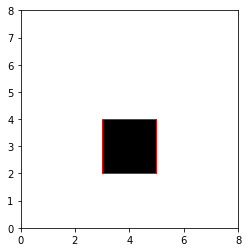

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Markdown

%matplotlib inline

# Create images with random rectangles and bounding boxes.
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]

imgs.shape, bboxes.shape

display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none',
           origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [0]:
# Reshape and normalize the image data to mean 0 and std 1.
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Task 1a
Construct a Pytorch model that resembles the Keras one in the original blog post, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = nn.Sequential(
    nn.Linear(64, 200),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(200, 4),
).to(device)

In [0]:
lr = 0.000001
optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=0.9)
loss_fn = torch.nn.MSELoss(size_average=False)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [0]:
inputs = Variable(torch.Tensor(train_X).to(device))
labels = Variable(torch.Tensor(train_y).to(device))

In [0]:
phase = 'train'
running_loss = 0.0
running_corrects = 0

loss_record = []
for epoch in range(20000):
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.data * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)
    if epoch % 1000 == 0:
        print(epoch)
print('done')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
done


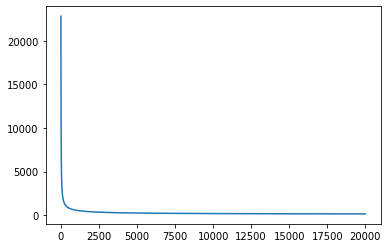

In [0]:
plt.plot(loss_record)

In [0]:
# change the model from training to evaluation mode to improve testing performance
phase = 'test'
model.eval()

Sequential(
  (0): Linear(in_features=64, out_features=200, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=200, out_features=4, bias=True)
)

In [0]:
# Predict bounding boxes on the test images.
pred_y = model(Variable(torch.cuda.FloatTensor(test_X)))
pred_bboxes = pred_y.data * img_size
pred_bboxes= pred_bboxes.cpu()
pred_bboxes = pred_bboxes.numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [0]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.9160153788762359

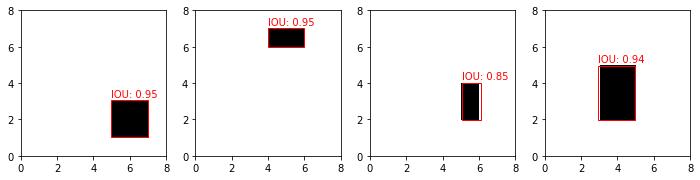

In [0]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs. Improve the training setup until you **reach a test IOU above 0.9**.

You can make the changes that move computation to the GPU directly in the cells above.

You may get stuck not achieving test IOU above 0.6. In that case, learn about switching the model to evaluation mode and apply the change above.

## Question 1c:
Why does `eval` mode above have such a significant effect on test performance? Please give a short answer below.

Dropout layer helps prevent overfitting problem in training phase so it should not be used in eval phase.

# Task 2: Use a pretrained model

As mentioned in class, deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll **work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)**, which also provides a ready-made jupyter notebook.

 1. Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.
 2. Perform your own training with the provided setup, fill out the answer to Task 2.2 below.
 3. Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type and use the "conv net as fixed feature extractor" approach, fill out the answer to Task 2.3 below.
 4. Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network without the modificiation that you applied in 2.3 above) so that you can detect one out of 1000 classes. Please fill out your the answer to Task 2.4 below.

# Your solution for Task 2

Before you start, get the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it into a subfolder `data`. The following import is going to attempt loading the image data from there.

Initialize much of the source code from the tutorial notebook located at
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
using [this module](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/tfl_tut.py)

In [0]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2020-03-10 10:14:09--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 143.204.175.48, 143.204.175.42, 143.204.175.114, ...
Connecting to download.pytorch.org (download.pytorch.org)|143.204.175.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: â€˜hymenoptera_data.zipâ€™

hymenoptera_data.zi 100%[===================>]  45.10M  27.3MB/s    in 1.7s    

2020-03-10 10:14:11 (27.3 MB/s) - â€˜hymenoptera_data.zipâ€™ saved [47286322/47286322]



In [0]:
!mkdir data
!unzip hymenoptera_data.zip
!mv hymenoptera_data data

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [0]:
from google.colab import files
uploaded = files.upload()

Saving tfl_tut.py to tfl_tut.py


In [0]:
from tfl_tut import *

Please study the original notebook and then continue to use its functions as imported from the `tfl_tut` model for convenience to minimize source code copy & paste.

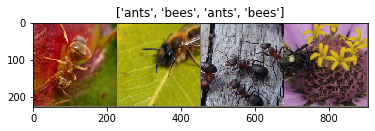

In [0]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


### Answer for Task 2.2

In [0]:
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=24)

Epoch 0/23
----------
train Loss: 0.6007 Acc: 0.6885
val Loss: 0.4323 Acc: 0.8301

Epoch 1/23
----------
train Loss: 0.4416 Acc: 0.8115
val Loss: 0.2194 Acc: 0.9085

Epoch 2/23
----------
train Loss: 0.4564 Acc: 0.7787
val Loss: 0.3470 Acc: 0.8758

Epoch 3/23
----------
train Loss: 0.4503 Acc: 0.8484
val Loss: 0.3181 Acc: 0.8562

Epoch 4/23
----------
train Loss: 0.4262 Acc: 0.8279
val Loss: 0.1950 Acc: 0.9150

Epoch 5/23
----------
train Loss: 0.9711 Acc: 0.7008
val Loss: 0.2998 Acc: 0.8954

Epoch 6/23
----------
train Loss: 0.5307 Acc: 0.7951
val Loss: 0.3147 Acc: 0.8954

Epoch 7/23
----------
train Loss: 0.3793 Acc: 0.8566
val Loss: 0.2386 Acc: 0.9085

Epoch 8/23
----------
train Loss: 0.3293 Acc: 0.8566
val Loss: 0.2274 Acc: 0.9216

Epoch 9/23
----------
train Loss: 0.3004 Acc: 0.8484
val Loss: 0.2322 Acc: 0.9281

Epoch 10/23
----------
train Loss: 0.2970 Acc: 0.8566
val Loss: 0.2342 Acc: 0.9281

Epoch 11/23
----------
train Loss: 0.3861 Acc: 0.8361
val Loss: 0.2266 Acc: 0.9281

Ep

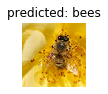

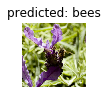

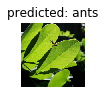

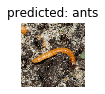

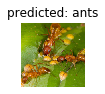

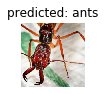

In [0]:
visualize_model(model_conv)

### Answer for Task 2.3

### Hints for this task

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = torchvision.models.resnet18(pretrained=True)
```
to load VGG16 instead. Set all its parameters to *not* require gradient computation, as shown in the tutorial.

Next, print out the new `model_conv` and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but it works similarily. The last classification step of the VGG model determines the probabilities for each of the 1000 classes of the dataset. Change this layer to identify only 2 classes to distinguish ants and bees as in the example.

To change the structure of some `Sequential` component called ```model_conv.module_name``` and to modify its last layer into a `DifferentLayer` type, you can use this syntax:

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old `model_conv.module_name` with this differently structured version.

In [0]:
model_conv = torchvision.models.vgg16(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
model_conv.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=24)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



Epoch 0/23
----------
train Loss: 0.3011 Acc: 0.8770
val Loss: 0.0855 Acc: 0.9739

Epoch 1/23
----------
train Loss: 0.1622 Acc: 0.9344
val Loss: 0.1068 Acc: 0.9673

Epoch 2/23
----------
train Loss: 0.2353 Acc: 0.9262
val Loss: 0.0813 Acc: 0.9739

Epoch 3/23
----------
train Loss: 0.1575 Acc: 0.9385
val Loss: 0.1399 Acc: 0.9542

Epoch 4/23
----------
train Loss: 0.1821 Acc: 0.9303
val Loss: 0.0955 Acc: 0.9739

Epoch 5/23
----------
train Loss: 0.1534 Acc: 0.9672
val Loss: 0.0974 Acc: 0.9673

Epoch 6/23
----------
train Loss: 0.1286 Acc: 0.9508
val Loss: 0.0771 Acc: 0.9673

Epoch 7/23
----------
train Loss: 0.0805 Acc: 0.9549
val Loss: 0.0680 Acc: 0.9739

Epoch 8/23
----------
train Loss: 0.1136 Acc: 0.9713
val Loss: 0.0726 Acc: 0.9804

Epoch 9/23
----------
train Loss: 0.0738 Acc: 0.9672
val Loss: 0.0761 Acc: 0.9739

Epoch 10/23
----------
train Loss: 0.1478 Acc: 0.9467
val Loss: 0.0720 Acc: 0.9804

Epoch 11/23
----------
train Loss: 0.1499 Acc: 0.9631
val Loss: 0.0676 Acc: 0.9804

E

In [37]:
# upload a pitcture
from google.colab import files
uploaded = files.upload()

Saving test.jpeg to test.jpeg


### Answer for Task 2.4

Egyptian cat


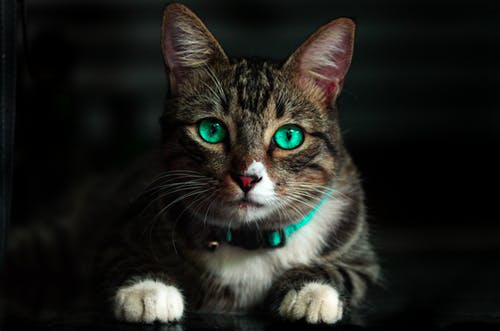

In [38]:
from PIL import Image
import io
import requests

model_conv = torchvision.models.vgg16(pretrained = True)
 
LABELS_URL = 'https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json'
labels = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   normalize
])

img_pil = Image.open("./test.jpeg")

img_tensor = preprocess(img_pil)
img_tensor.unsqueeze_(0)# create a mini-batch as expected by the model


img_variable = Variable(img_tensor)
fc_out = model_conv(img_variable)

print(labels[fc_out.data.numpy().argmax()])
display(img_pil)

Please include the picture and its class label in the saved notebook. It's OK, if we don't have the actual image file to reproduce the output.

## Submission

Your submission should be based on a modified version of [this notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/A8.ipynb) containing answers to Task 1 and for Task 2 including some portions of the transfer learning tutorial notebook in the sections above corresponding to tasks 2.1 - 2.4.